# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle
import random
from random import sample

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(777)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet/dcase2021_task2/ano_VAE+Centerloss/config.yaml'

In [7]:
torch.cuda.is_available()

True

In [8]:
#ext_data = pd.read_pickle(f'{INPUT_ROOT}/valve_features.pkl')

In [9]:
#train_features = ext_data['train']['features']

In [10]:
#train_features.shape

## training

In [11]:
def random_feature_selection(x, t_d=3776, d=2048):
    idx = torch.tensor(sample(range(0, t_d), d)) # t_d(特徴量)の中からランダムにd個サンプリングする(ぜんぶやると重いから) # わからん
    # 0~t_d idxの中からランダムにd個サンプリングする
    x = np.take(x, idx, 1)
    return x

In [12]:
#ext_data['train'].keys()

In [13]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine_type}_features.pkl')
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    num_classes = 6
    net = Model(in_features, mid_size, latent_size, num_classes)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [14]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

In [15]:
#path='/media/hiroki/HDD1TB/research/dcase2021_task2/output/CenterLossVAE/test_ex22/models/ToyCar_model.pth'
#pretrained_dict = torch.load(path)

In [16]:
#pretrained_dict['center_loss.centers'].shape

In [17]:
#pretrained_dict['center_loss.centers']

In [18]:
for machine_type in machine_types:
     run(machine_type)

2021-08-12 19:40:37,439 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-08-12 19:40:37,440 - 00_train.py - INFO - MAKE DATA_LOADER


FileNotFoundError: [Errno 2] No such file or directory: '/media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet_Barlow_Twins/dcase2021_task2/extraction_features/ToyCar_features.pkl'

2021-08-12 19:40:42,409 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-08-12 19:40:42,411 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-12 19:40:43,572 - 00_train.py - INFO - TRAINING
2021-08-12 19:40:46,922 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 12.96it/s]
2021-08-12 19:40:47,851 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 87.15it/s]
2021-08-12 19:40:47,901 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 76.52it/s]


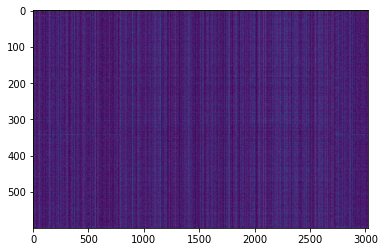

,AUC,pAUC
Source_0,0.507400,0.497895
Source_1,0.657500,0.504211
Source_2,0.732400,0.666842
Target_0,0.611100,0.539474
Target_1,0.612600,0.511579
Target_2,0.679400,0.542105
mean,0.633400,0.543684
h_mean,0.625144,0.538386


2021-08-12 19:40:49,399 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:32972.481608, val_AUC_hmean:0.625144, val_pAUC_hmean:0.538386, best_flag:True
2021-08-12 19:40:49,400 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.36it/s]
2021-08-12 19:40:49,875 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 96.15it/s]
2021-08-12 19:40:49,917 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 97.16it/s]


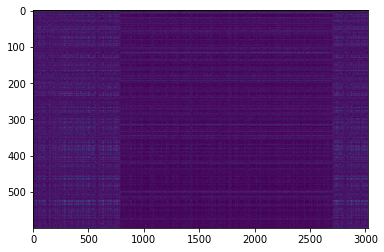

,AUC,pAUC
Source_0,0.529300,0.508421
Source_1,0.645800,0.514211
Source_2,0.760500,0.691579
Target_0,0.637700,0.528947
Target_1,0.631400,0.514737
Target_2,0.677400,0.526316
mean,0.647017,0.547368
h_mean,0.639602,0.540986


2021-08-12 19:40:51,211 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:25255.050944, val_AUC_hmean:0.639602, val_pAUC_hmean:0.540986, best_flag:True
2021-08-12 19:40:51,212 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.11it/s]
2021-08-12 19:40:51,657 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 93.72it/s]
2021-08-12 19:40:51,700 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 92.81it/s]
2021-08-12 19:40:51,748 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:21102.040365, val_AUC_hmean:0.649291, val_pAUC_hmean:0.539649, best_flag:False
2021-08-12 19:40:51,749 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 23.46it/s]
2021-08-12 19:40:52,263 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 102.36it/s]
2021-08-12 19:40:52,301 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 97.14it/s]


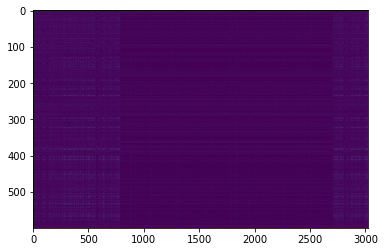

,AUC,pAUC
Source_0,0.523200,0.497895
Source_1,0.687700,0.543158
Source_2,0.792000,0.686842
Target_0,0.575700,0.500000
Target_1,0.667900,0.545789
Target_2,0.688500,0.556316
mean,0.655833,0.555000
h_mean,0.644140,0.548685


2021-08-12 19:40:53,733 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:18151.764486, val_AUC_hmean:0.644140, val_pAUC_hmean:0.548685, best_flag:True
2021-08-12 19:40:53,734 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.00it/s]
2021-08-12 19:40:54,181 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 91.06it/s]
2021-08-12 19:40:54,224 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 90.24it/s]


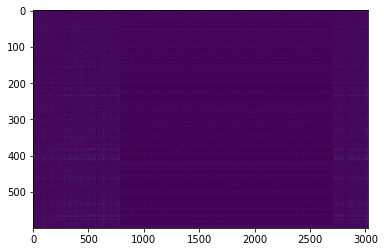

,AUC,pAUC
Source_0,0.522000,0.501579
Source_1,0.710300,0.548421
Source_2,0.832000,0.685789
Target_0,0.608500,0.501053
Target_1,0.679500,0.550000
Target_2,0.662800,0.570000
mean,0.669183,0.559474
h_mean,0.655788,0.553319


2021-08-12 19:40:55,508 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:16199.554036, val_AUC_hmean:0.655788, val_pAUC_hmean:0.553319, best_flag:True
2021-08-12 19:40:55,509 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.51it/s]
2021-08-12 19:40:55,981 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 94.79it/s]
2021-08-12 19:40:56,022 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 97.47it/s]
2021-08-12 19:40:56,065 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:14983.332926, val_AUC_hmean:0.641118, val_pAUC_hmean:0.551973, best_flag:False
2021-08-12 19:40:56,066 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.46it/s]
2021-08-12 19:40:56,505 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 94.64it/s]
2021-08-12 19:40:56,546 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 97.83it/s]
2021-08-12 19:4

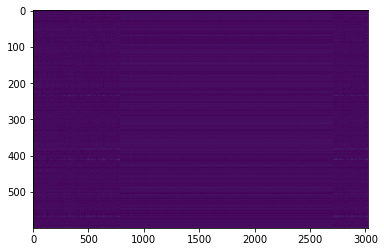

,AUC,pAUC
Source_0,0.448700,0.486316
Source_1,0.772700,0.563158
Source_2,0.840200,0.727368
Target_0,0.558900,0.496316
Target_1,0.713800,0.571579
Target_2,0.677000,0.551579
mean,0.668550,0.566053
h_mean,0.639638,0.556372


2021-08-12 19:40:58,931 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:13270.143066, val_AUC_hmean:0.639638, val_pAUC_hmean:0.556372, best_flag:True
2021-08-12 19:40:58,932 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.74it/s]
2021-08-12 19:40:59,400 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 88.94it/s]
2021-08-12 19:40:59,445 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 82.70it/s]
2021-08-12 19:40:59,492 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:12977.352132, val_AUC_hmean:0.643085, val_pAUC_hmean:0.550082, best_flag:False
2021-08-12 19:40:59,493 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.36it/s]
2021-08-12 19:40:59,950 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 81.32it/s]
2021-08-12 19:40:59,995 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 79.83it/s]
2021-08-12 19:

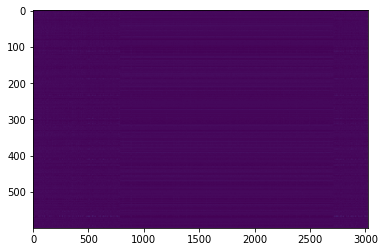

,AUC,pAUC
Source_0,0.430700,0.482632
Source_1,0.781400,0.587895
Source_2,0.856400,0.758421
Target_0,0.538200,0.495263
Target_1,0.750300,0.568947
Target_2,0.658600,0.553158
mean,0.669267,0.574386
h_mean,0.633015,0.562006


2021-08-12 19:41:02,306 - pytorch_modeler.py - INFO - epoch:13/100, train_losses:12149.989258, val_AUC_hmean:0.633015, val_pAUC_hmean:0.562006, best_flag:True
2021-08-12 19:41:02,306 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.74it/s]
2021-08-12 19:41:02,741 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 87.86it/s]
2021-08-12 19:41:02,785 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 89.23it/s]
2021-08-12 19:41:02,830 - pytorch_modeler.py - INFO - epoch:14/100, train_losses:11942.646159, val_AUC_hmean:0.640850, val_pAUC_hmean:0.557911, best_flag:False
2021-08-12 19:41:02,831 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.03it/s]
2021-08-12 19:41:03,278 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 74.80it/s]
2021-08-12 19:41:03,333 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 68.74it/s]
2021-08-12 19

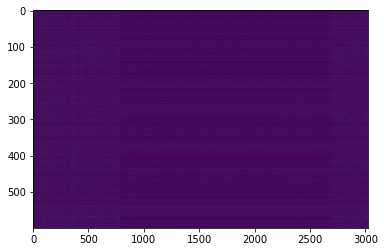

,AUC,pAUC
Source_0,0.419100,0.487895
Source_1,0.802600,0.600526
Source_2,0.846200,0.737895
Target_0,0.534800,0.503158
Target_1,0.748400,0.585789
Target_2,0.635500,0.537368
mean,0.664433,0.575439
h_mean,0.625432,0.564679


2021-08-12 19:41:05,685 - pytorch_modeler.py - INFO - epoch:17/100, train_losses:11458.243327, val_AUC_hmean:0.625432, val_pAUC_hmean:0.564679, best_flag:True
2021-08-12 19:41:05,686 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.93it/s]
2021-08-12 19:41:06,133 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 95.02it/s]
2021-08-12 19:41:06,175 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 92.46it/s]


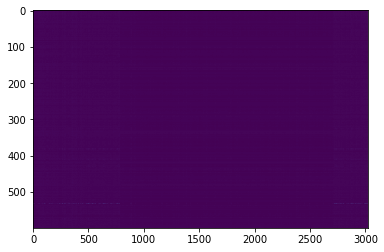

,AUC,pAUC
Source_0,0.444900,0.480526
Source_1,0.799700,0.621053
Source_2,0.839200,0.725789
Target_0,0.556400,0.495263
Target_1,0.753300,0.590526
Target_2,0.640900,0.556316
mean,0.672400,0.578246
h_mean,0.640011,0.567156


2021-08-12 19:41:07,507 - pytorch_modeler.py - INFO - epoch:18/100, train_losses:11307.286621, val_AUC_hmean:0.640011, val_pAUC_hmean:0.567156, best_flag:True
2021-08-12 19:41:07,508 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.90it/s]
2021-08-12 19:41:07,956 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 94.24it/s]
2021-08-12 19:41:08,001 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 91.75it/s]


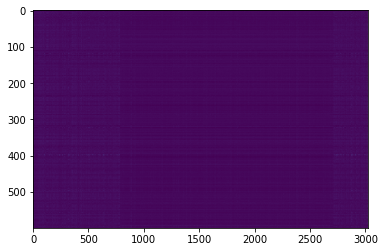

,AUC,pAUC
Source_0,0.403400,0.483684
Source_1,0.801500,0.620526
Source_2,0.847800,0.750000
Target_0,0.530400,0.491579
Target_1,0.752500,0.583158
Target_2,0.636100,0.558421
mean,0.661950,0.581228
h_mean,0.619037,0.568604


2021-08-12 19:41:09,292 - pytorch_modeler.py - INFO - epoch:19/100, train_losses:11160.122233, val_AUC_hmean:0.619037, val_pAUC_hmean:0.568604, best_flag:True
2021-08-12 19:41:09,293 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.52it/s]
2021-08-12 19:41:09,747 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 78.91it/s]
2021-08-12 19:41:09,795 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 75.25it/s]
2021-08-12 19:41:09,850 - pytorch_modeler.py - INFO - epoch:20/100, train_losses:11039.338949, val_AUC_hmean:0.616127, val_pAUC_hmean:0.557520, best_flag:False
2021-08-12 19:41:09,851 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.02it/s]
2021-08-12 19:41:10,314 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 98.74it/s]
2021-08-12 19:41:10,352 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 100.27it/s]


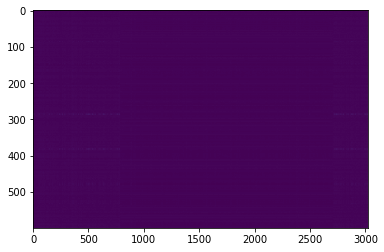

,AUC,pAUC
Source_0,0.416000,0.486842
Source_1,0.800900,0.631053
Source_2,0.851700,0.769474
Target_0,0.522600,0.503158
Target_1,0.752400,0.584737
Target_2,0.670500,0.568421
mean,0.669017,0.590614
h_mean,0.627577,0.577191


2021-08-12 19:41:11,571 - pytorch_modeler.py - INFO - epoch:21/100, train_losses:10884.139893, val_AUC_hmean:0.627577, val_pAUC_hmean:0.577191, best_flag:True
2021-08-12 19:41:11,572 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.34it/s]
2021-08-12 19:41:12,029 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 74.65it/s]
2021-08-12 19:41:12,077 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 101.74it/s]
2021-08-12 19:41:12,122 - pytorch_modeler.py - INFO - epoch:22/100, train_losses:10773.962240, val_AUC_hmean:0.624205, val_pAUC_hmean:0.559844, best_flag:False
2021-08-12 19:41:12,123 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.16it/s]
2021-08-12 19:41:12,566 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 98.02it/s]
2021-08-12 19:41:12,605 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 84.18it/s]
2021-08-12 1

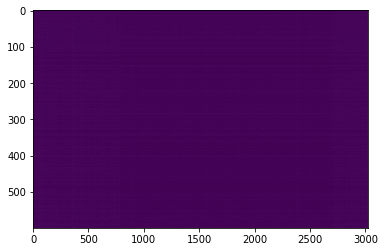

,AUC,pAUC
Source_0,0.413900,0.489474
Source_1,0.801000,0.648421
Source_2,0.851600,0.771053
Target_0,0.522900,0.514737
Target_1,0.761100,0.602105
Target_2,0.643700,0.535263
mean,0.665700,0.593509
h_mean,0.623794,0.579488


2021-08-12 19:41:17,286 - pytorch_modeler.py - INFO - epoch:29/100, train_losses:10056.342529, val_AUC_hmean:0.623794, val_pAUC_hmean:0.579488, best_flag:True
2021-08-12 19:41:17,287 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.64it/s]
2021-08-12 19:41:17,724 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 85.29it/s]
2021-08-12 19:41:17,768 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 92.14it/s]
2021-08-12 19:41:17,814 - pytorch_modeler.py - INFO - epoch:30/100, train_losses:9944.847900, val_AUC_hmean:0.640465, val_pAUC_hmean:0.564447, best_flag:False
2021-08-12 19:41:17,815 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.35it/s]
2021-08-12 19:41:18,256 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 79.87it/s]
2021-08-12 19:41:18,299 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 92.85it/s]
2021-08-12 19:

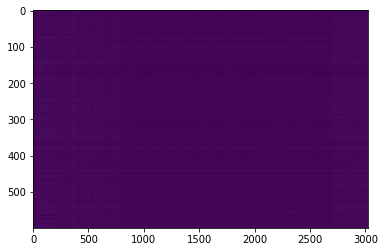

,AUC,pAUC
Source_0,0.423900,0.491053
Source_1,0.811900,0.670000
Source_2,0.844000,0.767895
Target_0,0.543000,0.522632
Target_1,0.759300,0.580000
Target_2,0.651100,0.538947
mean,0.672200,0.595088
h_mean,0.633577,0.581157


2021-08-12 19:41:21,176 - pytorch_modeler.py - INFO - epoch:34/100, train_losses:9548.377767, val_AUC_hmean:0.633577, val_pAUC_hmean:0.581157, best_flag:True
2021-08-12 19:41:21,177 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.52it/s]
2021-08-12 19:41:21,615 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 84.51it/s]
2021-08-12 19:41:21,661 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 84.35it/s]
2021-08-12 19:41:21,709 - pytorch_modeler.py - INFO - epoch:35/100, train_losses:9505.709066, val_AUC_hmean:0.613530, val_pAUC_hmean:0.570310, best_flag:False
2021-08-12 19:41:21,710 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.69it/s]
2021-08-12 19:41:22,198 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 88.00it/s]
2021-08-12 19:41:22,239 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 83.34it/s]
2021-08-12 19:4

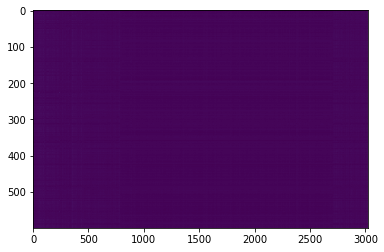

,AUC,pAUC
Source_0,0.376600,0.489474
Source_1,0.807700,0.655789
Source_2,0.860000,0.776316
Target_0,0.524700,0.515263
Target_1,0.753700,0.564737
Target_2,0.690000,0.585263
mean,0.668783,0.597807
h_mean,0.616135,0.583876


2021-08-12 19:41:25,665 - pytorch_modeler.py - INFO - epoch:40/100, train_losses:9099.742594, val_AUC_hmean:0.616135, val_pAUC_hmean:0.583876, best_flag:True
2021-08-12 19:41:25,665 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.69it/s]
2021-08-12 19:41:26,101 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 75.16it/s]
2021-08-12 19:41:26,148 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 93.75it/s]
2021-08-12 19:41:26,192 - pytorch_modeler.py - INFO - epoch:41/100, train_losses:9063.247965, val_AUC_hmean:0.629943, val_pAUC_hmean:0.574090, best_flag:False
2021-08-12 19:41:26,194 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.91it/s]
2021-08-12 19:41:26,641 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 97.43it/s]
2021-08-12 19:41:26,680 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.02it/s]
2021-08-12 19:4

100%|██████████| 2/2 [00:00<00:00, 82.45it/s]
2021-08-12 19:41:35,364 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 87.55it/s]


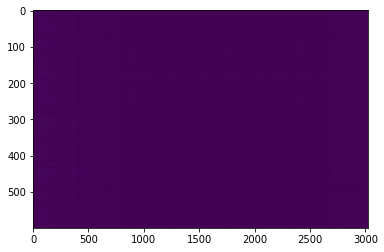

,AUC,pAUC
Source_0,0.404600,0.492632
Source_1,0.818600,0.691579
Source_2,0.843900,0.767368
Target_0,0.526100,0.520000
Target_1,0.771500,0.574211
Target_2,0.653900,0.551053
mean,0.669767,0.599474
h_mean,0.624714,0.584890


2021-08-12 19:41:36,504 - pytorch_modeler.py - INFO - epoch:57/100, train_losses:7931.209147, val_AUC_hmean:0.624714, val_pAUC_hmean:0.584890, best_flag:True
2021-08-12 19:41:36,505 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.47it/s]
2021-08-12 19:41:36,960 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 83.82it/s]
2021-08-12 19:41:37,006 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 83.26it/s]
2021-08-12 19:41:37,058 - pytorch_modeler.py - INFO - epoch:58/100, train_losses:7871.477946, val_AUC_hmean:0.621845, val_pAUC_hmean:0.583390, best_flag:False
2021-08-12 19:41:37,059 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.33it/s]
2021-08-12 19:41:37,517 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 96.83it/s]
2021-08-12 19:41:37,555 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 102.82it/s]
2021-08-12 19:

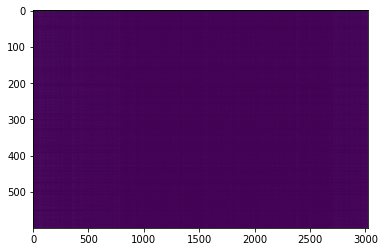

,AUC,pAUC
Source_0,0.389600,0.492632
Source_1,0.809800,0.701579
Source_2,0.836900,0.772105
Target_0,0.527200,0.512105
Target_1,0.768100,0.552632
Target_2,0.673300,0.583684
mean,0.667483,0.602456
h_mean,0.619806,0.586743


2021-08-12 19:41:40,325 - pytorch_modeler.py - INFO - epoch:62/100, train_losses:7610.110270, val_AUC_hmean:0.619806, val_pAUC_hmean:0.586743, best_flag:True
2021-08-12 19:41:40,326 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.32it/s]
2021-08-12 19:41:40,768 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 101.34it/s]
2021-08-12 19:41:40,807 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 101.82it/s]
2021-08-12 19:41:40,850 - pytorch_modeler.py - INFO - epoch:63/100, train_losses:7542.013062, val_AUC_hmean:0.629695, val_pAUC_hmean:0.578459, best_flag:False
2021-08-12 19:41:40,851 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.62it/s]
2021-08-12 19:41:41,287 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 93.50it/s]
2021-08-12 19:41:41,327 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 96.59it/s]
2021-08-12 19

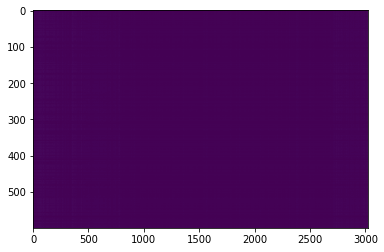

,AUC,pAUC
Source_0,0.398300,0.493684
Source_1,0.809500,0.691579
Source_2,0.844300,0.780526
Target_0,0.518900,0.513684
Target_1,0.772800,0.561579
Target_2,0.675000,0.582105
mean,0.669800,0.603860
h_mean,0.622856,0.588347


2021-08-12 19:41:44,977 - pytorch_modeler.py - INFO - epoch:68/100, train_losses:7247.539673, val_AUC_hmean:0.622856, val_pAUC_hmean:0.588347, best_flag:True
2021-08-12 19:41:44,981 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.13it/s]
2021-08-12 19:41:45,460 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 94.71it/s]
2021-08-12 19:41:45,501 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 100.52it/s]
2021-08-12 19:41:45,545 - pytorch_modeler.py - INFO - epoch:69/100, train_losses:7183.414632, val_AUC_hmean:0.633746, val_pAUC_hmean:0.578960, best_flag:False
2021-08-12 19:41:45,546 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.19it/s]
2021-08-12 19:41:46,006 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 86.49it/s]
2021-08-12 19:41:46,052 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 77.75it/s]
2021-08-12 19:

100%|██████████| 2/2 [00:00<00:00, 87.25it/s]
2021-08-12 19:41:54,446 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 92.43it/s]
2021-08-12 19:41:54,492 - pytorch_modeler.py - INFO - epoch:85/100, train_losses:6365.842611, val_AUC_hmean:0.622671, val_pAUC_hmean:0.580927, best_flag:False
2021-08-12 19:41:54,493 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.45it/s]
2021-08-12 19:41:54,948 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 85.97it/s]
2021-08-12 19:41:54,991 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 75.57it/s]
2021-08-12 19:41:55,050 - pytorch_modeler.py - INFO - epoch:86/100, train_losses:6300.113932, val_AUC_hmean:0.624674, val_pAUC_hmean:0.587544, best_flag:False
2021-08-12 19:41:55,051 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.82it/s]
2021-08-12 19:41:55,518 - pytorch_modeler.py - INFO - valid_source
100%|█████████

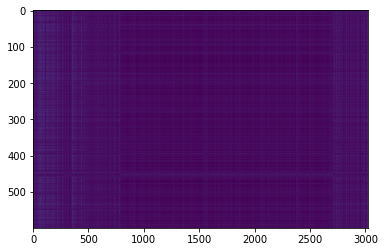

,AUC,pAUC
Source_0,0.401000,0.495789
Source_1,0.815300,0.709474
Source_2,0.853600,0.776842
Target_0,0.527700,0.526316
Target_1,0.766300,0.563684
Target_2,0.665000,0.563684
mean,0.671483,0.605965
h_mean,0.625289,0.590445


2021-08-12 19:41:57,799 - pytorch_modeler.py - INFO - epoch:89/100, train_losses:6179.025513, val_AUC_hmean:0.625289, val_pAUC_hmean:0.590445, best_flag:True
2021-08-12 19:41:57,800 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.40it/s]
2021-08-12 19:41:58,275 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 87.21it/s]
2021-08-12 19:41:58,317 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 93.38it/s]
2021-08-12 19:41:58,362 - pytorch_modeler.py - INFO - epoch:90/100, train_losses:6125.142537, val_AUC_hmean:0.621640, val_pAUC_hmean:0.574564, best_flag:False
2021-08-12 19:41:58,363 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.19it/s]
2021-08-12 19:41:58,806 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 83.00it/s]
2021-08-12 19:41:58,849 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 85.04it/s]
2021-08-12 19:4

,AUC,pAUC
Source_0,0.401000,0.495789
Source_1,0.815300,0.709474
Source_2,0.853600,0.776842
Target_0,0.527700,0.526316
Target_1,0.766300,0.563684
Target_2,0.665000,0.563684
mean,0.671483,0.605965
h_mean,0.625289,0.590445


elapsed time: 81.387979269 [sec]


In [19]:
run(machine_types[5])